### Cat vs Dog Classification

In [2]:
import os
from pathlib import Path

folder = "Colab Notebooks"
project_dir = "02_cnn_tf (2)"
base_path = Path("/content/drive/My Drive")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/Colab Notebooks/02_cnn_tf (2)


# Convolutional Neural Network: Cat-Dog Classifier

- CNN을 설계하고 이미지 분류기를 학습시킨다.
- 학습 과정에서 데이터 증식(data augmentation)을 적용한다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 전이학습(transfer learning)을 구현할 수 있다.
- 학습된 모델을 저장하고 불러올 수 있다.
- 전이학습(transfer learning)을 구현할 수 있다.

### 1. Package load

In [3]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import check_util.checker as checker
from IPython.display import clear_output
from PIL import Image

import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers

print('tensorflow version: {}'.format(tf.__version__))
print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: True


## 2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구분



In [4]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

In [4]:
checker.dataset_check(data_dir)

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000
dataset이 제대로 구성되어 있습니다! 이어서 진행하셔도 좋습니다.


## 3. Hyperparameter Setting
- BATCH_SIZE, max_epoch, learning_rate등의 정보를 저장해줌
- 이러한 정보도 미리 저장해두고 나중에 변수로 갖다 써야 코드가 길어질 때에 불편하지 않다.


In [5]:
print_steps = 1
val_epoch = 1

batch_size = 20
max_epochs = 100
learning_rate = 1e-4
IMG_SIZE = 150

PATH = data_dir

## 4. tf.data.Dataset을 이용하여 Input Pipeline 만들기
1. tf.data.Dataset.list_files를 이용하여 **폴더 안에 있는 파일 리스트를 가지고** tf.data.Dataset을 만든다.
  - 우리가 tfds, 즉 tensorflow dataset으로 쉽게 가져다 쓰는 데이터들은 모두 이미 tf.data.Dataset의 형태로 구성이 되어 있는 상태이다.

2. tf.data.Dataset.map()을 이용해서 **사용자 정의 함수를 적용해** data augmentation을 진행한다.





### 데이터 증식(Data Augmentation) 함수

우리는 이번 실습에서 모델을 학습시키는 데에 비교적 적은 양의 데이터셋을 사용하고 있습니다. 이처럼 적은 양의 훈련 데이터를 통해 학습시킨 모델은 오버피팅의 문제가 매우 심각할 수 있습니다. 데이터 증식(data augmentation) 기법은 이러한 작은 데이터셋의 한계를 어느정도 극복하기 위한 좋은 방법입니다. 데이터 증식은 학습할 때 기존의 데이터에 약간의 변형을 가해 모델에 넣어주는 기법을 말합니다. 이렇게 함으로써 모델은 실질적으로 매 epoch마다 서로 다른 데이터를 학습하게 됩니다. 실제로 데이터를 늘리는 것은 아니지만 모델 입장에서는 같은 데이터가 매번 다른 변형을 통해 들어가기 때문에 다양한 이미지처럼 느끼고 다양한 패턴을 고려하여 학습하게 됩니다.

<img src="https://drive.google.com/uc?id=1b0o9nVH8sDQyv_jSvRjjm5WT0jQ6XYxH" width="600px" height="400px" />
<caption><center>&lt;데이터 증식을 통한 학습과정 도식화&gt;</center></caption>

데이터 증식 기법에는 여러가지가 있으며, 우리는 모델 훈련과정에서 다양한 증식 기법을 랜덤하게 적용하여 훈련용 데이터를 증식하는 효과를 얻는다.

<img src="https://drive.google.com/uc?id=1wvJplIH2Ky04-75m8I6g5lmCO6fcx16I" width="800px" height="200px" />

**사실 Tensorflow 안에 존재하는 다양한 이미지 처리 API가 존재하며, 자동으로 이미지 데이터를 증식시키는 API인 ```tf.keras.preprocessing.image.ImageDataGenertator```이 존재하는 것은 맞다. 그러나 직접 함수를 만들어 보는 방법으로 이를 학습하면 훨씬 더 도움이 될 것이다.**

1. Image Load Function
  - ```tf.io.read_file```을 이용해서 파일 저장 경로를 하나 입력 받으면 그 파일을 읽어서 jpeg파일로 디코딩한 후에 float의 형태로 바꾸어 준다.

In [6]:
def load(image_file, label):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32)

  return image, label

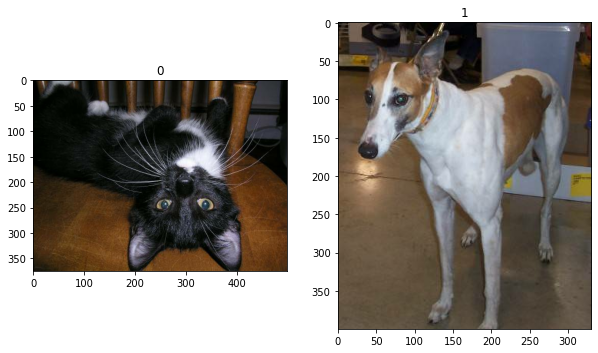

In [25]:
image_c, label_c = load(os.path.join(PATH, 'test/cat/cat.2222.jpg'), 0)
image_d, label_d = load(os.path.join(PATH, 'test/dog/dog.2222.jpg'), 1)


plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title(label_c)
plt.imshow(image_c/255.0)
plt.subplot(1,2,2)
plt.title(label_d)
plt.imshow(image_d/255.0)

plt.show()

In [26]:
image_c.shape

TensorShape([375, 499, 3])

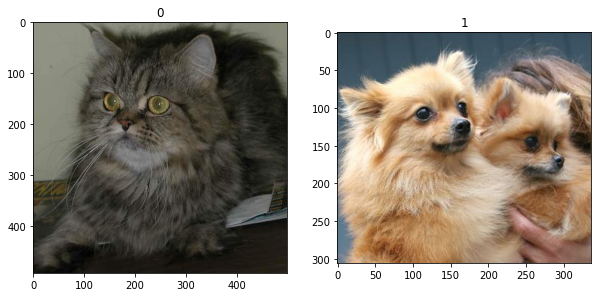

In [7]:
image_c, label_c = load(os.path.join(PATH, 'train/cat/cat.86.jpg'), 0)
image_d, label_d = load(os.path.join(PATH, 'train/dog/dog.77.jpg'), 1)


plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.title(label_c)
plt.imshow(image_c/255.0)
plt.subplot(1,2,2)
plt.title(label_d)
plt.imshow(image_d/255.0)

plt.show()

2. Image Resize Function
  - 이미지를 원하는 사이즈 (width, height)로 변환하는 과정이다.
  - argument로 image와 resizing 하고 싶은 height, width를 받아서 resizing이 가능하다.
  - ```tf.image.resize()```를 사용하기로 한다.

In [8]:
def resize(input_image, height, weight):
  img = tf.image.resize(input_image, (height, weight))
  return img

3. Random Rotation Function
  - 이미지를 임의의, random한 각도로 회전을 시킨다.
  - random하게 회전할 각도를 angle이라는 변수로 설정하고 ```np.random.randint```를 이용해서 0~3 사이의 정수를 뽑아낸다.
  - ```tf.image.rot90()```을 이용해서 입력이미지와 회전하고자 하는 수 를 전달하면 된다.
    - 이 API는 90도만 회전이 가능하기 떄문에 회전 수를 지정해 주면 90, 180, 270이렇게 회전 가능하다.

In [9]:
def random_rotation(input_image):
  angle = np.random.randint(3)
  img = tf.image.rot90(input_image, angle)
  return img

4. Random Crop Function
  - 이미지를 원하는 size로 crop하는 함수이다.
  -```tf.image.random_crop(image, size)```로 구현한다.

In [10]:
def random_crop(input_image):
  img = tf.image.random_crop(input_image, [256,256,3])
  return img

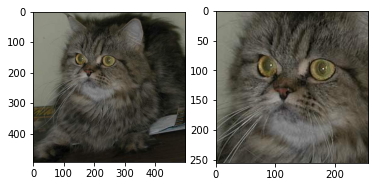

In [11]:
plt.figure()
plt.subplot(1, 2,1)
plt.imshow(image_c/255.0)
plt.subplot(1,2,2)
plt.imshow(random_crop(image_c)/255.0)
plt.show()

5. Normalize Function
- 이미지 데이터는 일반적으로 [0, 255]사이의 픽셀값으로 이루어져 있다.
- 이때 이 값의 범위를 **[-1,1]로 바꾸어주는 과정**을 normalization이라고 한다

In [12]:
def normalization(input_image):
  img = (input_image/127.5)-1
  return img

6. Random Jitter Function
- 학습시 image augmentation를 위해서 만든 함수들을 이용하는데, 추가적으로 ```tf.image.random_flip_left_right```도 이용할 생각이다.

In [13]:
def random_jitter(input_image):
  img = resize(input_image, 300, 300)
  img = random_crop(img)
  img = random_rotation(img)
  img = tf.image.random_flip_left_right(img)
  return img

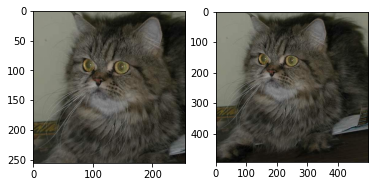

In [14]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(random_jitter(image_c)/255.0)
plt.subplot(1,2,2)
plt.imshow(image_c/255.0)
plt.show()

7. Central Crop Function
- 학습을 할 때에는 다양한 데이터가 있으면 좋기 떄문에 random_jitter함수를 이용하지만 validation, test data로는 적합하지 않기 때문에 val, test data를 위해서 이미지를 augment하는 함수를 만들어야 한다.
  - 이를 위해서는 resize를 먼저 한 이후에 전체 이미지에서 얼마의 비율로 잘라낼지 정하는 central_fraction이라는 인자가 존재한다.

In [15]:
def central_crop(input_image):
  img = resize(input_image, 300, 300)
  img = tf.image.central_crop(img, 256/300)
  return img

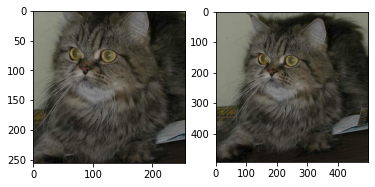

In [16]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(central_crop(image_c)/255.0)
plt.subplot(1,2,2)
plt.imshow(image_c/255.0)
plt.show()

8. Load Image Train Function
- 학습용 이미지를 load하는 pipeline을 만들어야 하는데, 순서로는 
  1. image load
  2. random_jitter
  3. normalize
이다. 

In [17]:
def load_train_image(image_file, label):
  img, label = load(image_file, label)
  img = random_jitter(img)
  img = normalization(img)
  return img, label

9. Load Image Val, Test Function
- validation, test image pipeline을 만들어야 한다.

In [18]:
def load_test_img(image_file, label):
  img, label = load(image_file, label)
  img = central_crop(img)
  img = normalization(img)
  return img, label

#### Input Pipeline
- data_dir이 모든 데이터셋이 저장되어 있는 장소이고, 이 정보와 ```os.path.join()```을 이용해서 모든 directory를 리스트에 저장한 뒤에 ```tf.data.Dataset.list_files()```를 이용해서 dataset의 형태로 만들어준다.
  - 여기서 ```tf.data.Dataset.from_tensor_slices```는 이용하면 안된다.
  
- 고양이와 강아지 데이터를 모두 불러 왔으면 label을 붙여주는데, 이때 ```tf.data.Dataset.map()```을 이용해 준다.
- 고양이와 강아지 데이터를 ```tf.data.Dataset.concatenate()```를 이용해서 합친다.

In [19]:
def add_label(input_image, label):
  return input_image, label

folder_list = [i for i in os.listdir(os.path.join(data_dir, 'train'))if not i.startswith('.')]

In [20]:
folder_list

['cat', 'dog']

In [21]:
train_dataset = tf.data.Dataset.list_files(
    os.path.join(data_dir, 'train', folder_list[0], '*.jpg')
)
train_dataset = train_dataset.map(lambda x: add_label(x, 0))
dog_dataset = tf.data.Dataset.list_files(
    os.path.join(data_dir, 'train', folder_list[1], '*jpg')
)
dog_dataset = dog_dataset.map(lambda x: add_label(x,1))
train_dataset = train_dataset.concatenate(dog_dataset)

In [22]:
len(list(train_dataset))

2000

In [23]:
BUFFER_SIZE = len(train_dataset)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=16)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.repeat()

In [29]:
test_folder_list = [i for i in os.listdir(os.path.join(data_dir, 'test'))if not i.startswith('.')]
test_dataset = tf.data.Dataset.list_files(
    os.path.join(data_dir, 'test', test_folder_list[0], '*jpg')
)
test_dataset = test_dataset.map(lambda x: add_label(x, 0))
test_dog_dataset = tf.data.Dataset.list_files(
    os.path.join(data_dir, 'test', test_folder_list[1], '*jpg')
)
test_dog_dataset = test_dog_dataset.map(lambda x: add_label(x, 1))
test_dataset = test_dataset.concatenate(test_dog_dataset)
test_dataset = test_dataset.map(load_train_image)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

In [31]:
test_dog_dataset

<MapDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [30]:
test_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [31]:
val_folder_list = [i for i in os.listdir(os.path.join(data_dir, 'val'))if not i.startswith('.')]
val_dataset = tf.data.Dataset.list_files(
    os.path.join(data_dir, 'val', val_folder_list[0], '*jpg')
)
val_dataset = val_dataset.map(lambda x: add_label(x,0))
val_dog_dataset = tf.data.Dataset.list_files(
    os.path.join(data_dir, 'val', val_folder_list[1], '*jpg')
)
val_dog_dataset = val_dog_dataset.map(lambda x: add_label(x, 1))
val_dataset = val_dataset.concatenate(val_dog_dataset)
val_dataset = val_dataset.map(load_train_image)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.repeat()


In [32]:
train_dataset, val_dataset, test_dataset

(<RepeatDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>,
 <RepeatDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>,
 <RepeatDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>)

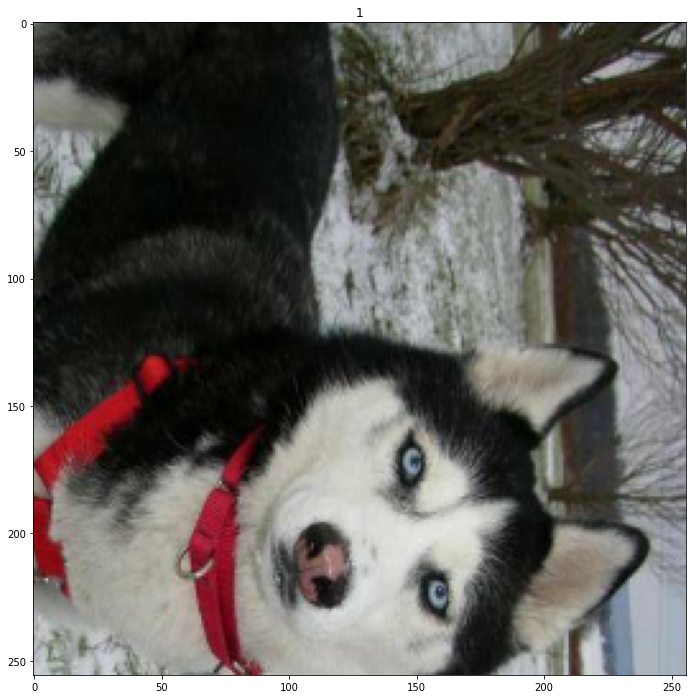

In [34]:
plt.figure(figsize = (12,12))
for img, label in test_dataset.take(1):
  for j in range(1):
    plt.subplot(1,1,j+1)
    plt.imshow((img[j]+1)/2)
    plt.title(label[j].numpy())
plt.show()

### 5. Conv Layer(Conv - BatchNorm - ReLU - Pool) 만들기
- convolution 연산을 하고 나면 주로 batch normalization - relu - maxpooling이런 식으로 연산을 하게 되는데, 따라서 자주 쓰이는 (Conv - Batch - ReLU - MaxPool)을 **class의 형태로 만들면 훨씬 편리**하다.

In [35]:
class Conv(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(Conv, self).__init__()

    self.conv = tf.keras.layers.Conv2D(filters, kernel_size)
    self.bn = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D()

  def call(self, inputs, training = True):
    x = self.conv(inputs)
    x = self.bn(x)
    x = self.relu(x)
    x = self.pool(x)
    return x
  
  def build(self, batch_input_shape):
    super().build(batch_input_shape)

In [36]:
model = tf.keras.models.Sequential()

model.add(Conv(32, (2,2)))
model.add(Conv(64, (2,2)))
model.add(Conv(128, (2,2)))
model.add(Conv(256, (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(512, activation = tf.keras.activations.selu))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))



**여기까지만 진행을 해게 되면 아직 모델이 build 된 것이 아니다.**  
이렇게 사용자 정의 함수를 이용해서 모델을 설계하기 위해서는 마지막에 꼭 'build'처리를 해야 하는데, 그 방법으로는  
1. class안에 build 함수 만들기
2. model의 입력층에 넣을 입력 데이터를 넣어서 활성화 시키기

In [37]:
model.build((None,256,256,3))

In [32]:
for img, label in train_dataset.take(1):
  model(img[1:])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv)                  (None, 127, 127, 32)      544       
_________________________________________________________________
conv_1 (Conv)                (None, 63, 63, 64)        8512      
_________________________________________________________________
conv_2 (Conv)                (None, 31, 31, 128)       33408     
_________________________________________________________________
conv_3 (Conv)                (None, 15, 15, 256)       132352    
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dropout (Dropout)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

#### 6. Saving the Model

In [34]:
checkpoint_path = './train/exp_cnn/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only = True, save_freq = 'epoch', vebose = 1)

### 7. Loss and Optimizer

In [39]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
    loss = 'sparse_categorical_crossentropy'
)

In [40]:
train_len = len(glob(os.path.join(data_dir, 'train', folder_list[0], '*jpg')))*2
test_len = len(glob(os.path.join(data_dir, 'test', test_folder_list[0], '*jpg')))*2
val_len = len(glob(os.path.join(data_dir, 'val', val_folder_list[0], '*jpg')))*2

In [41]:
model.fit(
    train_dataset, 
    steps_per_epoch = train_len/batch_size,
    validation_data = val_dataset,
    validation_steps = val_len/batch_size,
    epochs = 20
)

Epoch 1/20
100/100 [==============================] - 25s 248ms/step - loss: 4.1739 - accuracy: 0.5270 - val_loss: 0.6968 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 24s 245ms/step - loss: 0.6611 - accuracy: 0.6035 - val_loss: 0.7035 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 25s 250ms/step - loss: 0.6619 - accuracy: 0.6250 - val_loss: 0.6798 - val_accuracy: 0.5840
Epoch 4/20
100/100 [==============================] - 25s 248ms/step - loss: 0.6135 - accuracy: 0.6560 - val_loss: 0.6534 - val_accuracy: 0.6050
Epoch 5/20
100/100 [==============================] - 24s 243ms/step - loss: 0.6209 - accuracy: 0.6665 - val_loss: 0.6401 - val_accuracy: 0.6450
Epoch 6/20
100/100 [==============================] - 24s 241ms/step - loss: 0.6347 - accuracy: 0.6710 - val_loss: 0.6462 - val_accuracy: 0.6090
Epoch 7/20
100/100 [==============================] - 24s 244ms/step - loss: 0.5689 - accuracy: 0.7170 - val_loss: 0.5503 - val_ac

### 8. Evaluation

In [42]:
model.evaluate(test_dataset, steps = test_len/batch_size)

100/100 [==============================] - 4s 43ms/step - loss: 0.7424 - accuracy: 0.6630


[0.742436408996582, 0.6629999876022339]

## Accuracy = 66.30%

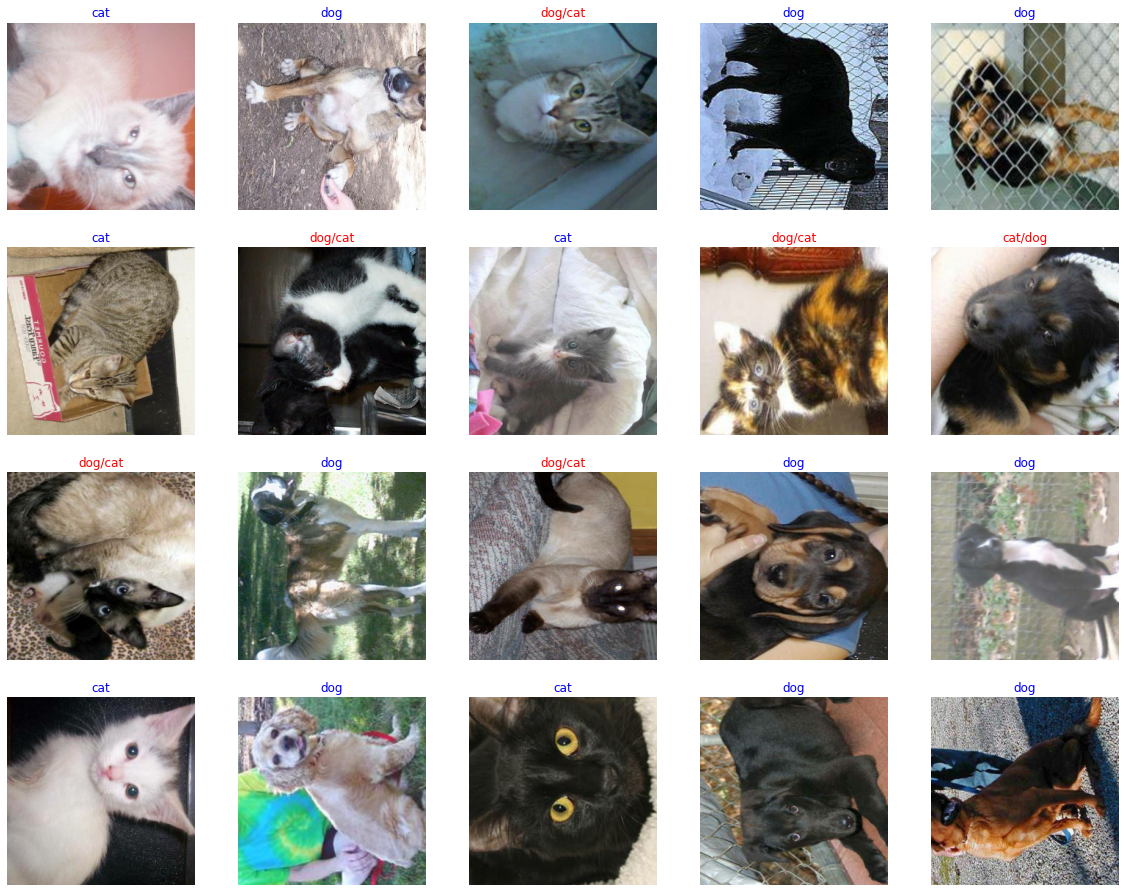

In [45]:
plt.figure(figsize = (20,20))
for images, labels in test_dataset.take(1):
  predictions = model(images)

test_batch_size = 25
images = images[:test_batch_size]
labels = labels[:test_batch_size]
predictions = predictions[:test_batch_size]

labels_map = {0:'cat', 1:'dog'}

for i, (img, y, pred_y) in enumerate(zip(images, labels, predictions)):
  plt.subplot(5,5,i+1)
  if np.argmax(pred_y.numpy()) == y.numpy():
    plt.title('{}'.format(labels_map[y.numpy()]), color = 'b')
  else:
    plt.title('{}/{}'.format(labels_map[np.argmax(pred_y.numpy())], labels_map[y.numpy()]), color = 'r')
  plt.imshow(((img.numpy())+1)*0.5)
  plt.axis('off')

### 9. Transfer Learning
- 전이 학습을 처음으로 시도해 보고자 한다.
- 전이 학습이란 비슷한 목적으로 미리 학습된 모델의 파라미터를 이용해서 나의 모델의 파라미터를 초기화 한 후에 학습을 이어서 진행하는 것이다.  
  - 전이학습은 데이터 부족, 컴퓨터 성능 부족, 시간 부족등 다양한 문제가 있을 때 더 잘, 미리 학습이 된 모델이 있을 떄에 더 효율적일 수 있다.
  - 구현을 하기위해서는 미리 학습된 모델을 불러와야 하는데, 이를 위해서 VGG16이라는 모델을 사용해 보고자 한다.

- 사용하기 위해서는 ```tf.keras.application```을 이용해서 VGG16을 불러와야 한다.

In [46]:
conv_base = tf.keras.applications.VGG16(weights = 'imagenet',
                                        include_top = False,
                                        input_shape = (256, 256, 3))

58892288/58889256 [==============================] - 2s 0us/step


In [47]:
new_model = tf.keras.Sequential()
new_model.add(conv_base)
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(512, activation = tf.keras.activations.selu))
new_model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

In [48]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 31,493,442
Trainable params: 31,493,442
Non-trainable params: 0
_________________________________________________________________


In [51]:
new_model.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])
new_model.fit(train_dataset,
              steps_per_epoch = train_len/batch_size,
              validation_data = val_dataset,
              validation_steps = val_len/batch_size,
              epochs = 5)

Epoch 1/5
100/100 [==============================] - 100s 1s/step - loss: 0.7332 - accuracy: 0.4960 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 100s 1s/step - loss: 0.7430 - accuracy: 0.5130 - val_loss: 0.7111 - val_accuracy: 0.5000
Epoch 3/5
100/100 [==============================] - 100s 1000ms/step - loss: 0.9789 - accuracy: 0.4985 - val_loss: 0.7249 - val_accuracy: 0.5000
Epoch 4/5
100/100 [==============================] - 99s 993ms/step - loss: 0.7169 - accuracy: 0.4920 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 5/5
100/100 [==============================] - 100s 998ms/step - loss: 0.7263 - accuracy: 0.5050 - val_loss: 0.7701 - val_accuracy: 0.5000


In [53]:
new_model.evaluate(test_dataset, steps = test_len/batch_size)

100/100 [==============================] - 26s 259ms/step - loss: 0.7701 - accuracy: 0.5000


[0.770065188407898, 0.5]

### Accuracy = 50%